In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm 
from sklearn.utils import shuffle
import random
# %matplotlib inline
import torch.nn as nn
import torch.nn.functional as F
import os
# plt.style.use('dark_background')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed = 10
def set_seed(seed):
    print("Set Seed to",seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
device


device(type='cuda')

In [2]:
# reference_spectra=pd.read_csv('CS_interp.csv' , delimiter=',' , header= None )
reference_spectra=pd.read_csv('BSS-10.csv' , delimiter=',' , header= None )
interfere_spectra=pd.read_csv('BTEX.csv' , delimiter=',' , header= None )
ref_spec = reference_spectra.loc[1:,[1,2,3,4,5,6,7,8,9,10]]
df= reference_spectra.loc[:,[1,2,3,4,5,6,7,8,9,10]]
v=reference_spectra.loc[:,0]
downsampled_df = df.iloc[::4, :]
df1 = downsampled_df.interpolate(method='linear', limit_direction='forward', axis=0)
# Now, interpolated_df has shape (800, 10)
print(df1.shape)

(830, 10)


Text(0.5, 0, 'x')

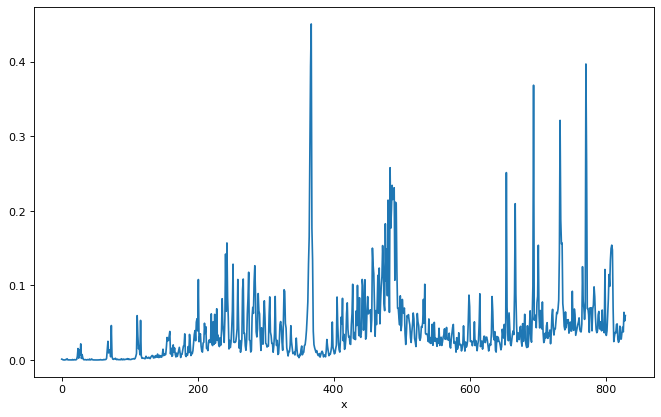

In [3]:
Nobs=10000
Con = np.zeros([int(Nobs),2])
Con[:,0] = np.random.random([int(Nobs)])
Con[:,1] = np.random.random([int(Nobs)])
#Con[:,0][np.random.random([Nobs]) > .25] = 0
#Con[:,1][np.random.random([Nobs]) > .25] = 0
dataset_clean=np.matmul(Con,[df1[1]/2, df1[2]/2]) #,df1[9] ,df1[10]]
fig = plt.figure(figsize=(10, 6), dpi=80)
plt.plot(dataset_clean[590,:])
plt.xlabel('x')

In [4]:
# leanring parameters
epochs =500
batch_size = 128
lr = 0.001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Spec_T = torch.tensor(dataset_clean)
Con_T = torch.tensor(Con)

train_features = Spec_T[:int(Nobs*0.9)]      #60% of df
val_features   = Spec_T[int(Nobs*0.9):int(Nobs)]#20% of df
test_features  = Spec_T[int(Nobs*0.9):int(Nobs)]#20% of df

train_targets = Con_T[:int(Nobs*0.9)]      #60% of df
val_targets   = Con_T[int(Nobs*0.9):int(Nobs)]#20% of df
test_targets  = Con_T[int(Nobs*0.9):int(Nobs)]#20% of df

train = torch.utils.data.TensorDataset(torch.Tensor(np.array(train_features)).to(device), torch.Tensor(np.array(train_targets)).to(device))
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)

val = torch.utils.data.TensorDataset(torch.Tensor(np.array(val_features)).to(device), torch.Tensor(np.array(val_targets)).to(device))
valid_loader = torch.utils.data.DataLoader(val, batch_size = batch_size)

test = torch.utils.data.TensorDataset(torch.Tensor(np.array(test_features)).to(device), torch.Tensor(np.array(test_targets)).to(device))
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size)

In [5]:
class Encoder(nn.Module):
    def __init__(self, latent_dims=8):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv1d(1, 128, 5, padding=2)
        self.bn1 = nn.BatchNorm1d(128)
        self.conv2 = nn.Conv1d(128, 128, 5, padding=2)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 128, 5, padding=2)
        self.bn3 = nn.BatchNorm1d(128)
        self.pool1 = nn.MaxPool1d(2, 2)
        self.conv4 = nn.Conv1d(128, 64, 5, padding=2)
        self.bn4 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(2, 2)
        self.conv5 = nn.Conv1d(64, 32, 5, padding=2)
        self.bn5 = nn.BatchNorm1d(32)
        self.pool3 = nn.MaxPool1d(2, 2)
        self.conv6 = nn.Conv1d(32, 16, 5, padding=2)
        self.bn6 = nn.BatchNorm1d(16)
        self.dropout = nn.Dropout(p=0.2)
        self.inter = nn.Linear(16 * 103, 18)  # intermediate fc layer
        self.linear2 = nn.Linear(18, latent_dims)  # intermediate fc layer

    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool1(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool3(x)
        x = F.relu(self.bn6(self.conv6(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.inter(x)
        z = self.linear2(x)
        if (z.max(axis=0).values - z.min(axis=0).values)[0] != 0 and (z.max(axis=0).values - z.min(axis=0).values)[1] != 0:
            z = (z - z.min(axis=0).values) / (z.max(axis=0).values - z.min(axis=0).values)
        return z
shape1=np.shape(df1)
latent_dims=2
class Decoder(nn.Module):
    def __init__(self, latent_dims=latent_dims):
        super(Decoder, self).__init__()
        self.r = nn.Parameter(torch.abs(torch.rand((latent_dims, shape1[0]))), requires_grad=True)
    def forward(self, z):
        x=torch.matmul(z,torch.abs(self.r))
        return z,x
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [6]:
def frobenius_norm(matrix):
    return np.linalg.norm(matrix, 'fro')

def train(autoencoder, train_loader, valid_loader, epochs=50):
    losses = {'train':[], 'validation':[]}
    valid_loss_min = np.Inf
    opt = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

    r_values = []  # List to store self.r values at each epoch
    x_hat_values = []  # List to store x_hat values at each epoch
    concentrations_values = []
    for epoch in range(epochs):
        train_loss = 0.0
        valid_loss = 0.0
        autoencoder.train()

        for x, y in train_loader:
            x = x.to(device)
            opt.zero_grad()
            z, x_hat = autoencoder(x)
            reconstruction_loss = ((x - x_hat)**2).sum()
            reconstruction_loss2 = torch.sum(torch.abs(x - x_hat) + torch.exp(-torch.abs(x - x_hat)) - 1)
            loss = reconstruction_loss + reconstruction_loss2
            loss.backward()
            opt.step()
            train_loss += loss.item() * x.size(0)

        autoencoder.eval()
        for x, y in valid_loader:
            x = x.to(device)
            z, x_hat = autoencoder(x)
            reconstruction_loss = ((x - x_hat)**2).sum()
            reconstruction_loss2 = torch.sum(torch.abs(x - x_hat) + torch.exp(-torch.abs(x - x_hat)) - 1)

            loss = reconstruction_loss + reconstruction_loss2
            # loss_fro = torch.norm(x - x_hat).sum()
            # loss = reconstruction_loss +loss_fro*0
            valid_loss += loss.item() * x.size(0)

        train_loss = train_loss / len(train_loader.dataset)
        valid_loss = valid_loss / len(valid_loader.dataset)

        losses['train'].append(train_loss)
        losses['validation'].append(valid_loss)

        # Save self.r values and x_hat at each epoch
        r_values.append(autoencoder.decoder.r.clone().detach().cpu().numpy())
        x_hat_values.append(x_hat.clone().detach().cpu().numpy())

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))

        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                  valid_loss_min, valid_loss))
            valid_loss_min = valid_loss

    # Convert the lists to numpy arrays
    r_values = np.array(r_values)
    x_hat_values = np.array(x_hat_values)

    return autoencoder, r_values, x_hat_values

In [7]:
latent_dims = 2
autoencoder = Autoencoder(latent_dims).to(device) # GPU
autoencoder, r_values, x_hat_values = train(autoencoder, train_loader,valid_loader,200)

Epoch: 0 	Training Loss: 9338.942396 	Validation Loss: 5319.242184
Validation loss decreased (inf --> 5319.242184).  Saving model ...
Epoch: 1 	Training Loss: 5372.077156 	Validation Loss: 5657.659078
Epoch: 2 	Training Loss: 4506.886418 	Validation Loss: 3331.639504
Validation loss decreased (5319.242184 --> 3331.639504).  Saving model ...
Epoch: 3 	Training Loss: 3689.616401 	Validation Loss: 3760.307793
Epoch: 4 	Training Loss: 4214.870617 	Validation Loss: 3110.725869
Validation loss decreased (3331.639504 --> 3110.725869).  Saving model ...
Epoch: 5 	Training Loss: 2894.952432 	Validation Loss: 2682.406494
Validation loss decreased (3110.725869 --> 2682.406494).  Saving model ...
Epoch: 6 	Training Loss: 2633.034601 	Validation Loss: 2199.445367
Validation loss decreased (2682.406494 --> 2199.445367).  Saving model ...
Epoch: 7 	Training Loss: 2271.723820 	Validation Loss: 2243.767991
Epoch: 8 	Training Loss: 1983.264428 	Validation Loss: 2117.152066
Validation loss decreased (219

# Animation 

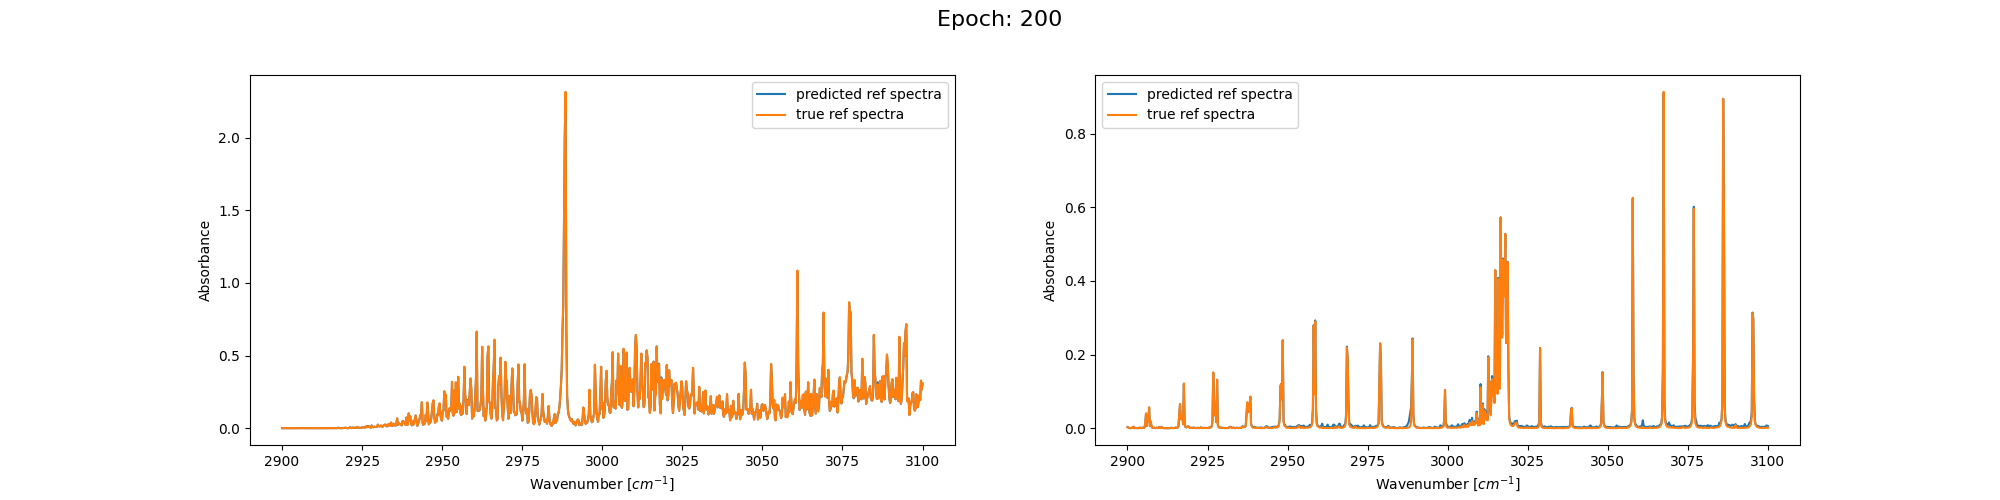

In [37]:
%matplotlib widget

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

# Example data setup
# Assuming r_values is your data with shape (200, 2, 830)
# v represents the x-values, which should have length 830
r_values_loaded = r_values
df2=[df1[2] , df1[1]]
v = np.linspace(2900, 3100, 830)  # Example x-values

fig, axs = plt.subplots(1, 2, figsize=(20, 5), facecolor='none')
fig.subplots_adjust(top=0.85)

def update(frame):
    fig.suptitle(f'Epoch: {frame+1}', fontsize=16, color='black')
    for i, ax in enumerate(axs):
        ax.clear()
        ax.set_facecolor('none')  # Set subplot background color to transparent
        ax.plot(v, np.abs(r_values_loaded[frame, i, :]), label="predicted ref spectra")
        ax.plot(v, df2[i] / 2, label="true ref spectra")  # Replace df2 with your true reference data

        # ax.set_title(f'species {i + 1}', color='white')
        ax.legend()
        ax.set_xlabel('Wavenumber [$cm^{-1}$]', color='black')
        ax.set_ylabel('Absorbance', color='black')

#         # Set tick labels color to white
#         ax.tick_params(axis='x', colors='white')
#         ax.tick_params(axis='y', colors='white')

#         # Set spines color to white
#         ax.spines['top'].set_color('white')
#         ax.spines['bottom'].set_color('white')
#         ax.spines['left'].set_color('white')
#         ax.spines['right'].set_color('white')

    return axs

animation = FuncAnimation(fig, update, frames=len(r_values_loaded), interval=50, repeat=False)
animation.save('animated_plot_transparent_white.gif', writer='pillow')
plt.show()


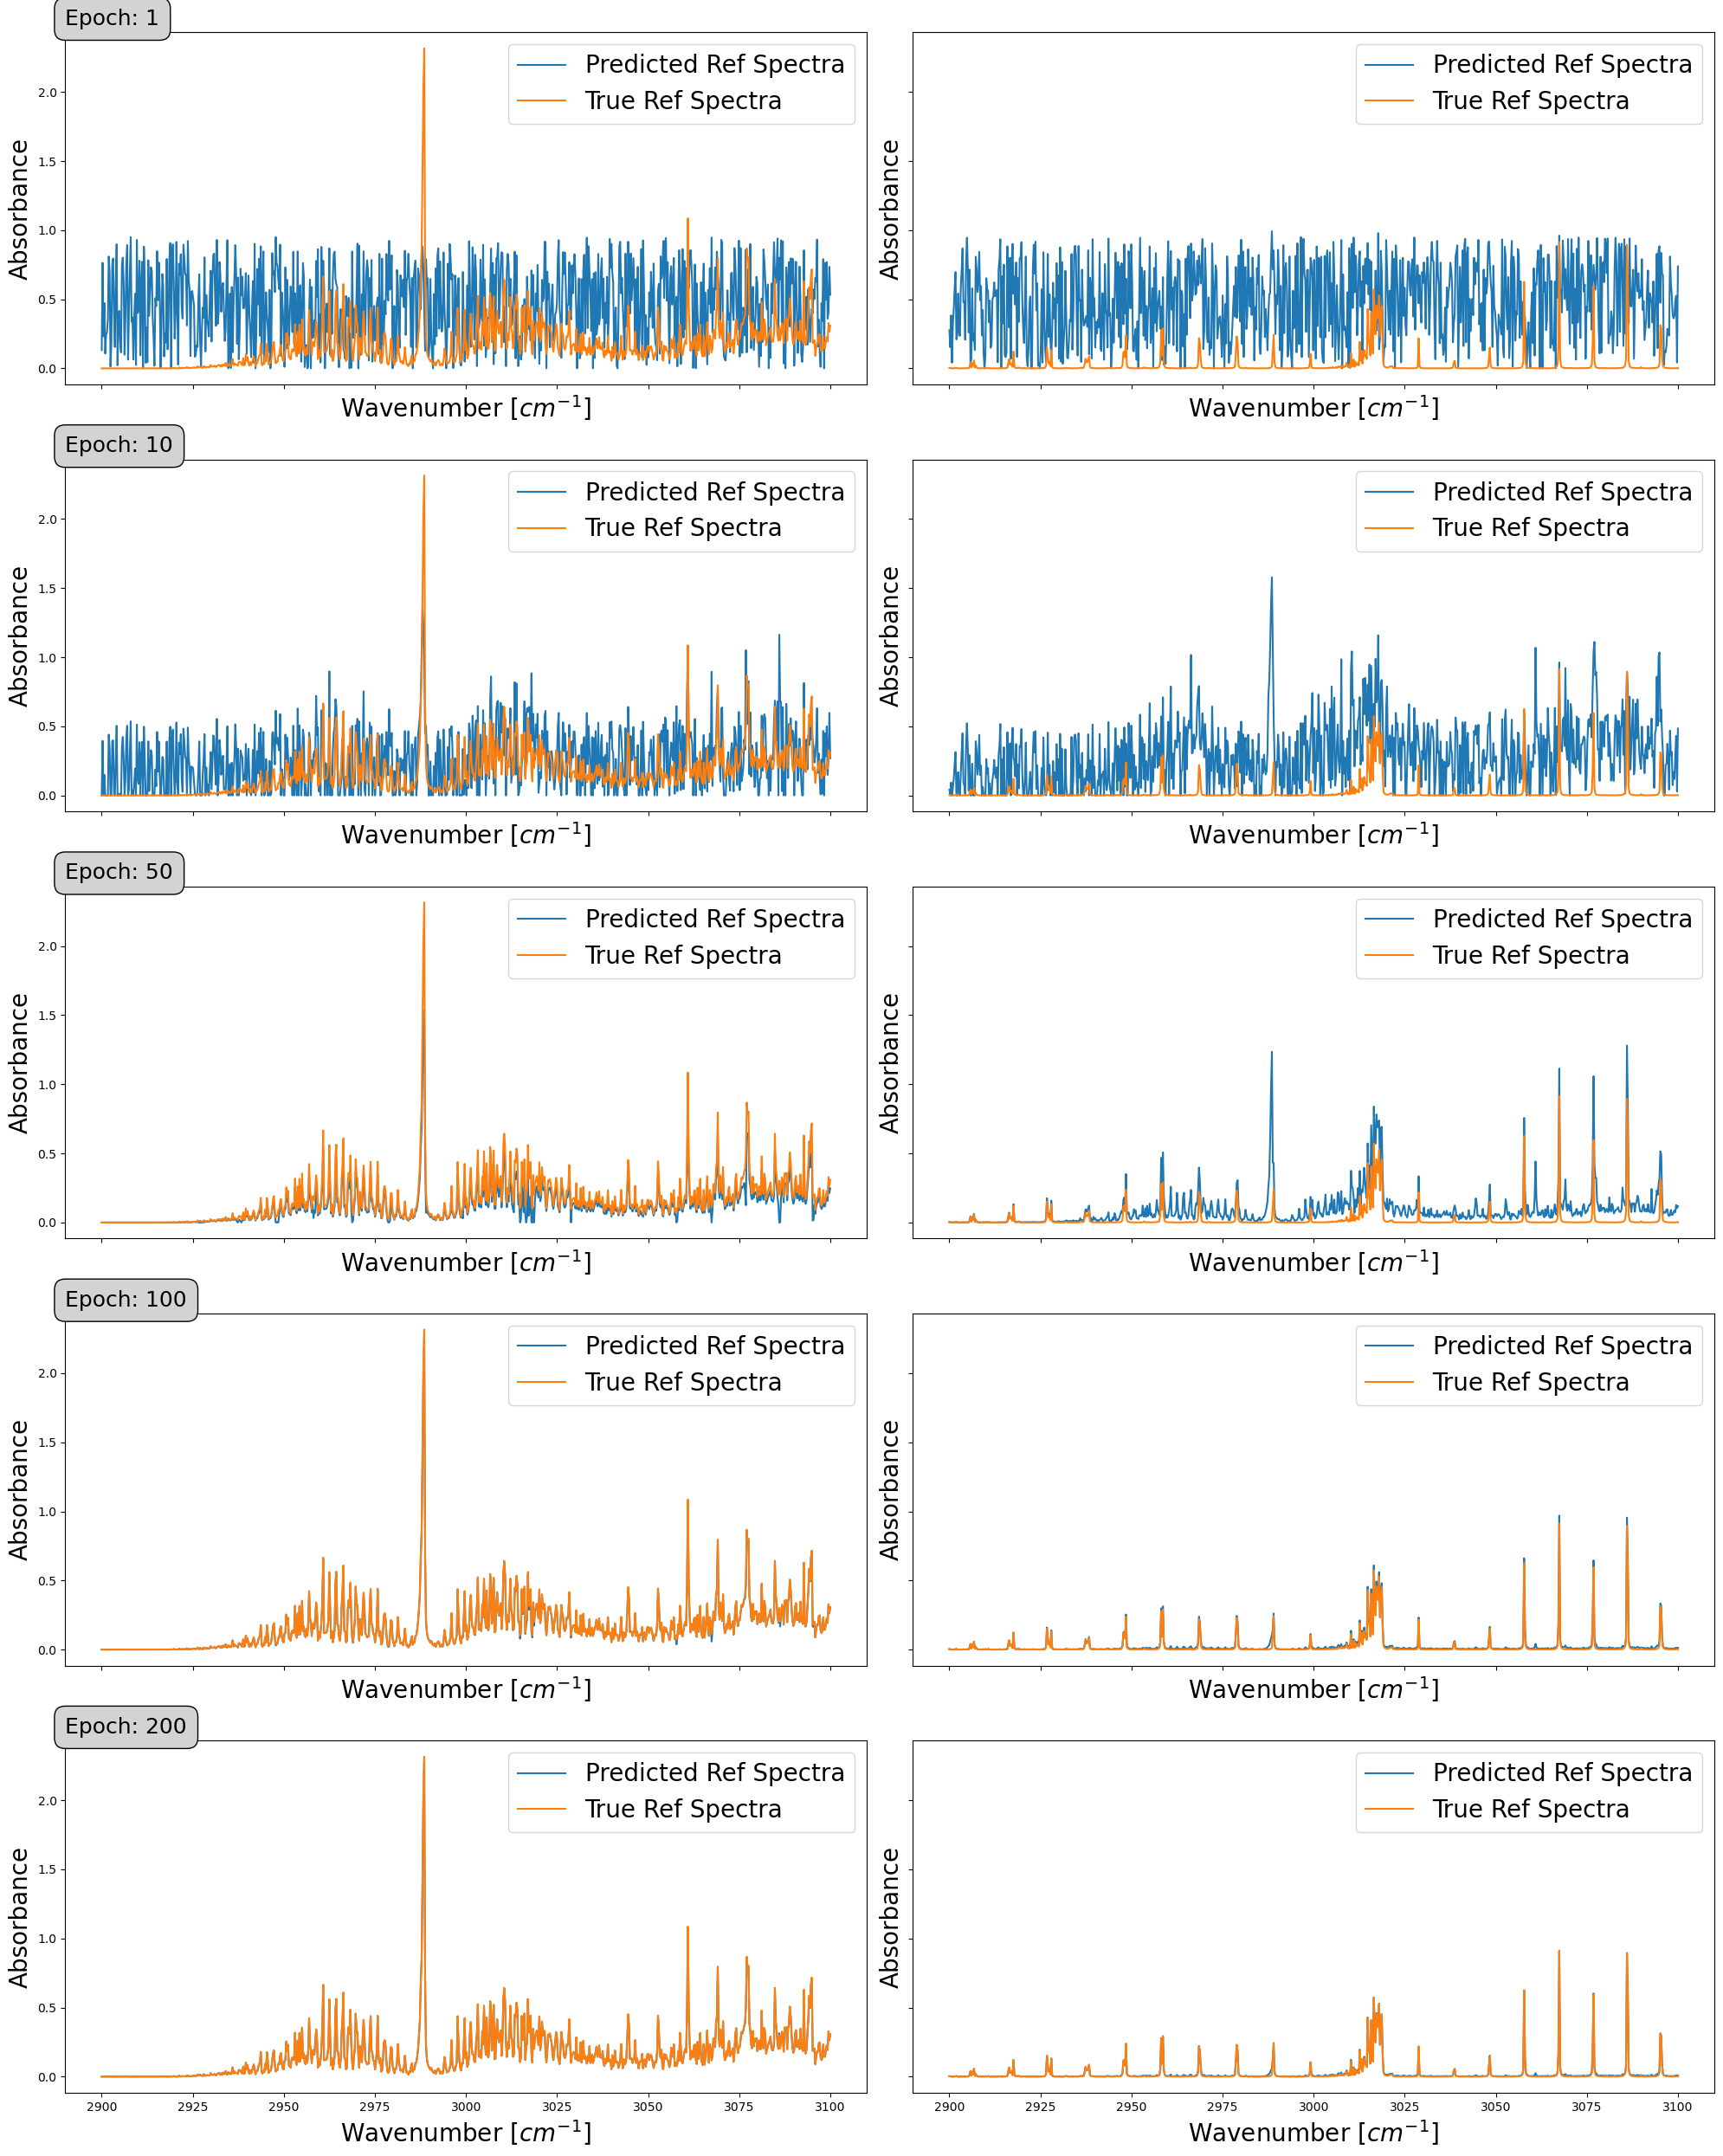

In [50]:
import matplotlib.pyplot as plt 
import numpy as np

# Assuming r_values is your data with shape (200, 2, 830)
# v represents the x-values, which should have length 830
r_values_loaded = r_values
df2 = [df1[2], df1[1]]  # Replace df1 with your true reference data
v = np.linspace(2900, 3100, 830)  # Example x-values

epochs = [1, 10, 50, 100, 200]
fig, axs = plt.subplots(len(epochs), 2, figsize=(20, 5 * len(epochs)), sharex=True, sharey=True)

for idx, epoch in enumerate(epochs):
    for i in range(2):
        ax = axs[idx, i]
        ax.plot(v, np.abs(r_values_loaded[epoch - 1, i, :]), label="Predicted Ref Spectra")
        ax.plot(v, df2[i] / 2, label="True Ref Spectra")  # Scaling true spectra for visualization
        ax.legend(fontsize=20)
        ax.set_xlabel('Wavenumber [$cm^{-1}$]', fontsize=20)
        ax.set_ylabel('Absorbance', fontsize=20)

    # Manually position the title for each row
    # fig.text(0.45, 0.89 - idx * 0.17, f'Epoch: {epoch}', fontsize=20, fontweight='bold')  # Adjust (x, y) coordinates as needed
    plt.sca(axs[idx, 0])  # Set the current axis to the left subplot of each row
    plt.title(f'Epoch: {epoch}', fontsize=18, loc='left', bbox=dict(facecolor='lightgrey', edgecolor='black', boxstyle='round,pad=0.5')) # Set the title above the subplots

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.6)  # Control horizontal and vertical space between plots
plt.tight_layout()
# plt.savefig('/home/sym/BSS/paper_figures/two/epoch_1_10_50.png', transparent=True, dpi=600)
plt.savefig('/home/sym/BSS/paper_figures/two/epoch_1_10_50.pdf', transparent=True, dpi=600)

plt.show()


## Evaluation and saving 

In [22]:
autoencoder.eval()  # Set the autoencoder to evaluation mode

total_size = 0  # Variable to store the total size of the test dataset

for x, y in test_loader:
    total_size += x.size(0)  # Increment the total size by the batch size

print("Full size of the test dataset:", total_size)

# Reset the test_loader iterator
test_loader_iter = iter(test_loader)
y_list = []
z_list = []

# Process the entire test dataset
for _ in range(total_size // batch_size):
    x, y = next(test_loader_iter)
    x = x.to(device)  # Move input data to GPU if available
    z, x_hat = autoencoder(x)
    # Process the output as desired
    y_list.append(y.cpu().detach().numpy())
    z_list.append(z.cpu().detach().numpy())

    
    
y_array = np.concatenate(y_list, axis=0)
z_array = np.concatenate(z_list, axis=0)

# Convert NumPy arrays to DataFrames
y_df = pd.DataFrame(y_array, columns=[f'y_{i}' for i in range(y_array.shape[1])])
z_df = pd.DataFrame(z_array, columns=[f'z_{i}' for i in range(z_array.shape[1])])
x_hat_df= pd.DataFrame(x_hat.cpu().detach().numpy())
x_df= pd.DataFrame(x.cpu().detach().numpy())

# Save DataFrames to CSV files
y_df.to_csv('2_y_data.csv', index=False)
z_df.to_csv('2_z_data.csv', index=False)
x_hat_df.to_csv('2_xhat.csv',index=False)
x_df.to_csv('2_x.csv',index=False)
spectras=autoencoder.decoder.r.clone().detach().cpu().numpy()
spectras[spectras<0]=0
filtered_2 =[spectras[0],spectras[1]]
filtered_2= pd.DataFrame(filtered_2)
filtered_2.to_csv('filtered_2.csv',index=False)

Full size of the test dataset: 1000


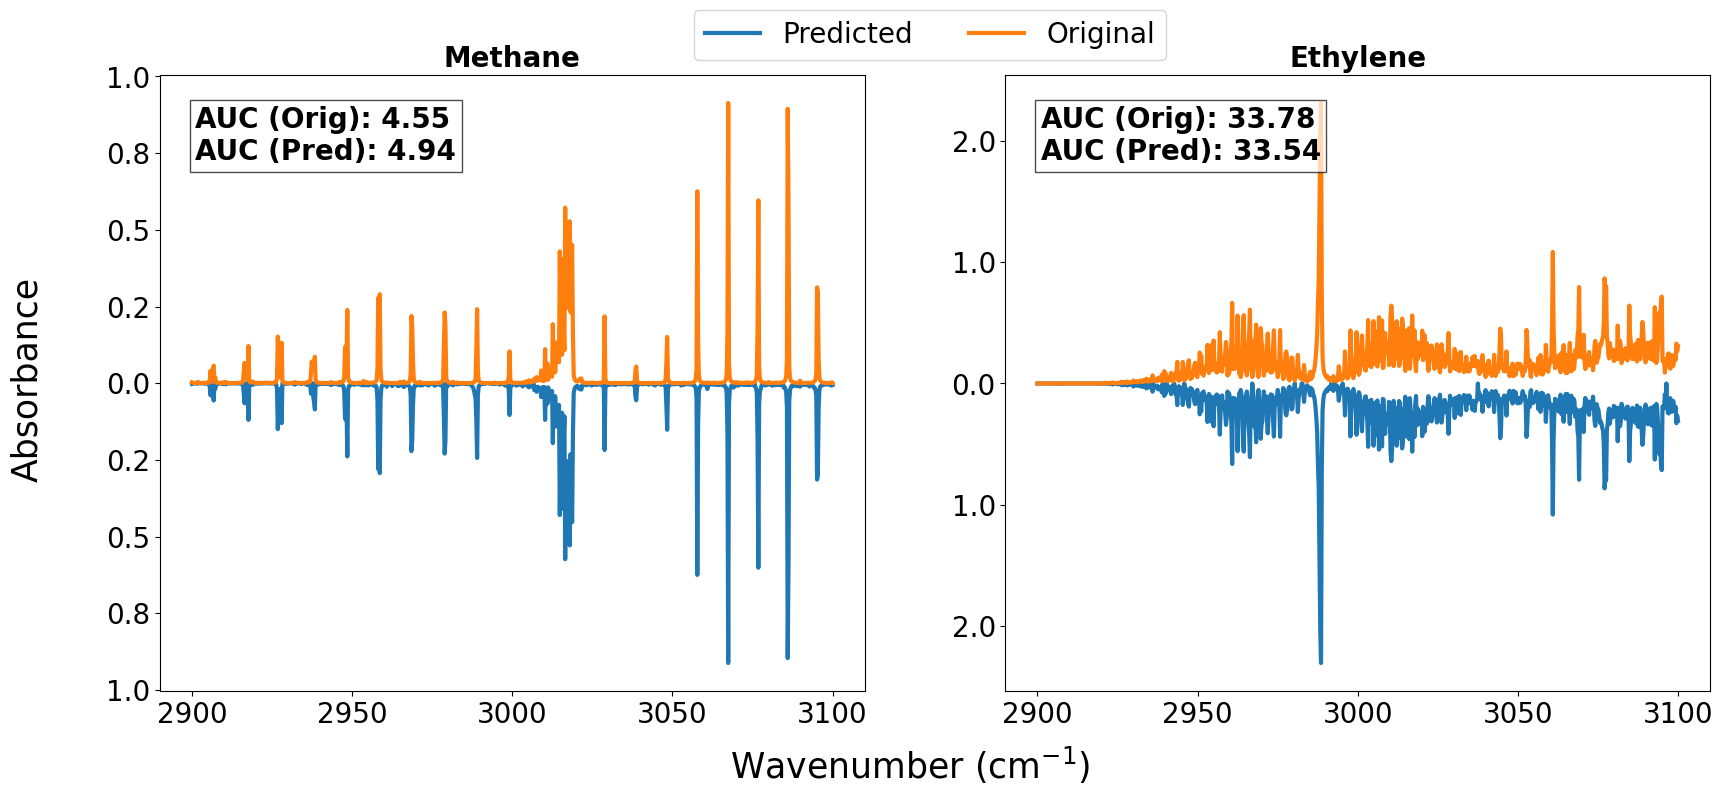

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from matplotlib.ticker import FuncFormatter

spectras=autoencoder.decoder.r.clone().detach().cpu().numpy()
spectras[spectras<0]=0
# filtered_up=[spectras[0],spectras[1]]
filtered_up = pd.read_csv('/home/sym/BSS/filtered_2.csv').to_numpy()
# filtered_all[filtered_all<0]=0
species = ['Methane', 'Ethylene', 'Ethane', 'Benzene', 'Propane', 'Toluene', 'Xylenes', 'Isoprene']
fig, axes = plt.subplots(1, 2, figsize=(20,8), sharex=True)  # Adjusted to 4 rows and 2 columns
x_values = np.linspace(2900, 3100, 830)
df4=[df1[1]/2, df1[2]/2]
# Assuming 'filtered_updated' and 'df3' are defined elsewhere in your code

mse_list = []
mae_list = []
area_df3_list = []
area_df4_list = []

for i, ax in enumerate(axes.flatten()):
    ax.plot(x_values, -filtered_up[i], linewidth=3)
    ax.plot(x_values, df4[i], linewidth=3)
    ax.set_title(species[i], fontsize=20, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=20)  # Increase tick label font size

    # Calculate MSE and MAE
    mse = mean_squared_error(filtered_up[i], df4[i])
    mae = mean_absolute_error(filtered_up[i], df4[i])
    mse_list.append(mse)
    mae_list.append(mae)

    # Calculate area under the curve using trapz
    area_df3 = np.trapz(df4[i], x_values)
    area_df4 = np.trapz(filtered_up[i], x_values)
    area_df3_list.append(area_df3)
    area_df4_list.append(area_df4)

    # Place the legend and area under the curve text inside the subplot
    legend_text = f'AUC (Orig): {area_df3:.2f}\nAUC (Pred): {area_df4:.2f}'
    ax.text(0.05, 0.95, legend_text, transform=ax.transAxes, va='top', ha='left', fontsize=20, fontweight='bold', bbox=dict(facecolor='white', alpha=0.7))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.1f}'.format(abs(x))))

# Set common x and y labels for the entire figure
fig.text(0.5, 0.00, 'Wavenumber (cm$^{-1}$)', ha='center', fontsize=25)
fig.text(0.05, 0.5, 'Absorbance', va='center', rotation='vertical', fontsize=25)

# Add a common legend at the top of the figure
fig.legend(["Predicted", "Original"], bbox_to_anchor=(0.51, 0.93), loc='center', fontsize=20, ncol=2)

# plt.savefig('/home/sym/BSS/paper_figures/two/BSS_4_up.png', transparent=True, dpi=600)
# plt.savefig('/home/sym/BSS/paper_figures/two/BSS_4_up.pdf', transparent=True, dpi=600)
# plt.style.use('default')

plt.show()


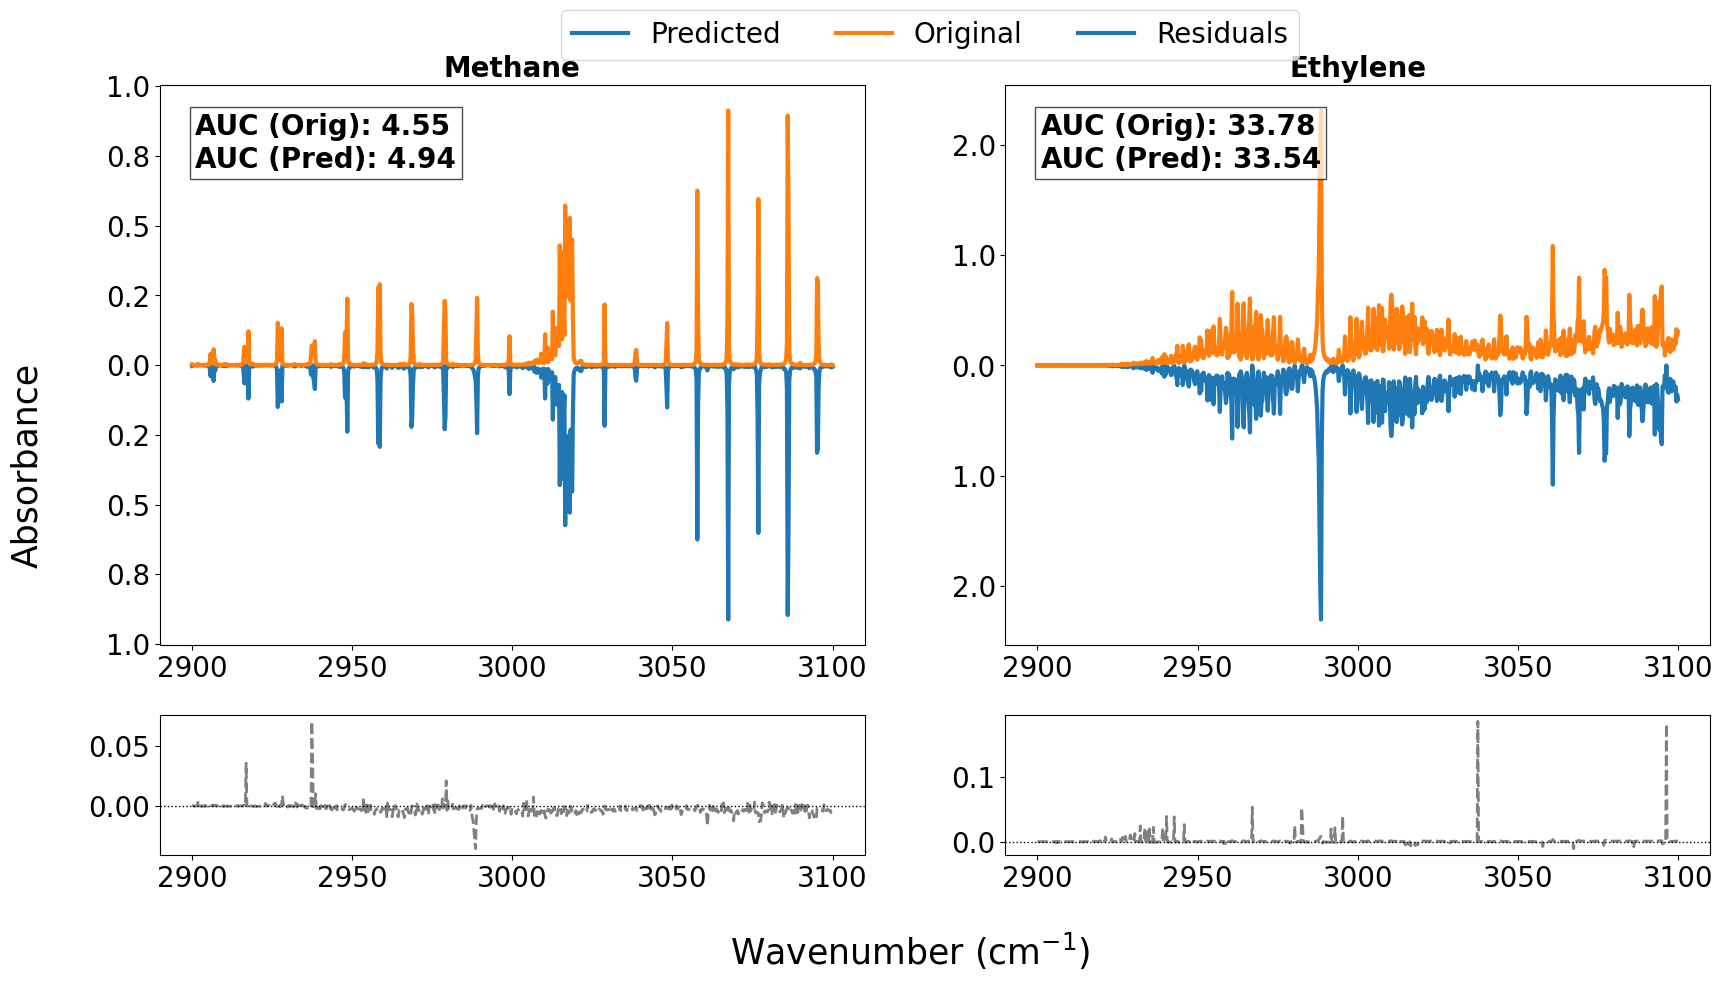

In [62]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from matplotlib.ticker import FuncFormatter

# Assuming 'filtered_up' and 'df4' are defined elsewhere in your code

fig, axes = plt.subplots(2, 2, figsize=(20, 10), gridspec_kw={'height_ratios': [4, 1]})
x_values = np.linspace(2900, 3100, 830)

mse_list = []
mae_list = []
area_df3_list = []
area_df4_list = []

for i, ax in enumerate(axes[0]):
    ax.plot(x_values, -filtered_up[i], linewidth=3)
    ax.plot(x_values, df4[i], linewidth=3)
    ax.set_title(species[i], fontsize=20, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=20)

    # Calculate residuals
    residuals = df4[i] - filtered_up[i]

    # Plot residuals
    ax_residuals = axes[1, i]
    ax_residuals.plot(x_values, residuals, linestyle='--', color='gray', linewidth=2)
    ax_residuals.axhline(y=0, color='black', linestyle=':', linewidth=1)  # Add horizontal line at y=0 for reference
    ax_residuals.tick_params(axis='both', which='major', labelsize=20)
    ax_residuals.xaxis.set_tick_params(labelbottom=True)  # Show x-axis labels for the residuals plot

    # Calculate MSE and MAE
    mse = mean_squared_error(filtered_up[i], df4[i])
    mae = mean_absolute_error(filtered_up[i], df4[i])
    mse_list.append(mse)
    mae_list.append(mae)

    # Calculate area under the curve using trapz
    area_df3 = np.trapz(df4[i], x_values)
    area_df4 = np.trapz(filtered_up[i], x_values)
    area_df3_list.append(area_df3)
    area_df4_list.append(area_df4)

    # Place the legend and area under the curve text inside the subplot
    legend_text = f'AUC (Orig): {area_df3:.2f}\nAUC (Pred): {area_df4:.2f}'
    ax.text(0.05, 0.95, legend_text, transform=ax.transAxes, va='top', ha='left', fontsize=20, fontweight='bold', bbox=dict(facecolor='white', alpha=0.7))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.1f}'.format(abs(x))))

# Set common x and y labels for the entire figure
fig.text(0.5, 0.00, 'Wavenumber (cm$^{-1}$)', ha='center', fontsize=25)
fig.text(0.05, 0.5, 'Absorbance', va='center', rotation='vertical', fontsize=25)

# Add a common legend at the top of the figure
fig.legend(["Predicted", "Original", "Residuals"], bbox_to_anchor=(0.51, 0.93), loc='center', fontsize=20, ncol=3)

# plt.savefig('/home/sym/BSS/paper_figures/two/BSS_4_up.png', transparent=True, dpi=600)
# plt.savefig('/home/sym/BSS/paper_figures/two/BSS_4_up.pdf', transparent=True, dpi=600)
# plt.style.use('default')

plt.show()


In [4]:
predicted = pd.read_csv('/home/sym/BSS/2_z_data.csv').to_numpy()
true = pd.read_csv('/home/sym/BSS/2_y_data.csv').to_numpy()
predicted=[predicted[:,0].T,predicted[:,1].T]#,predicted[:,7].T,predicted[:,5].T,predicted[:,3].T,predicted[:,0].T,predicted[:,1].T,predicted[:,4].T]

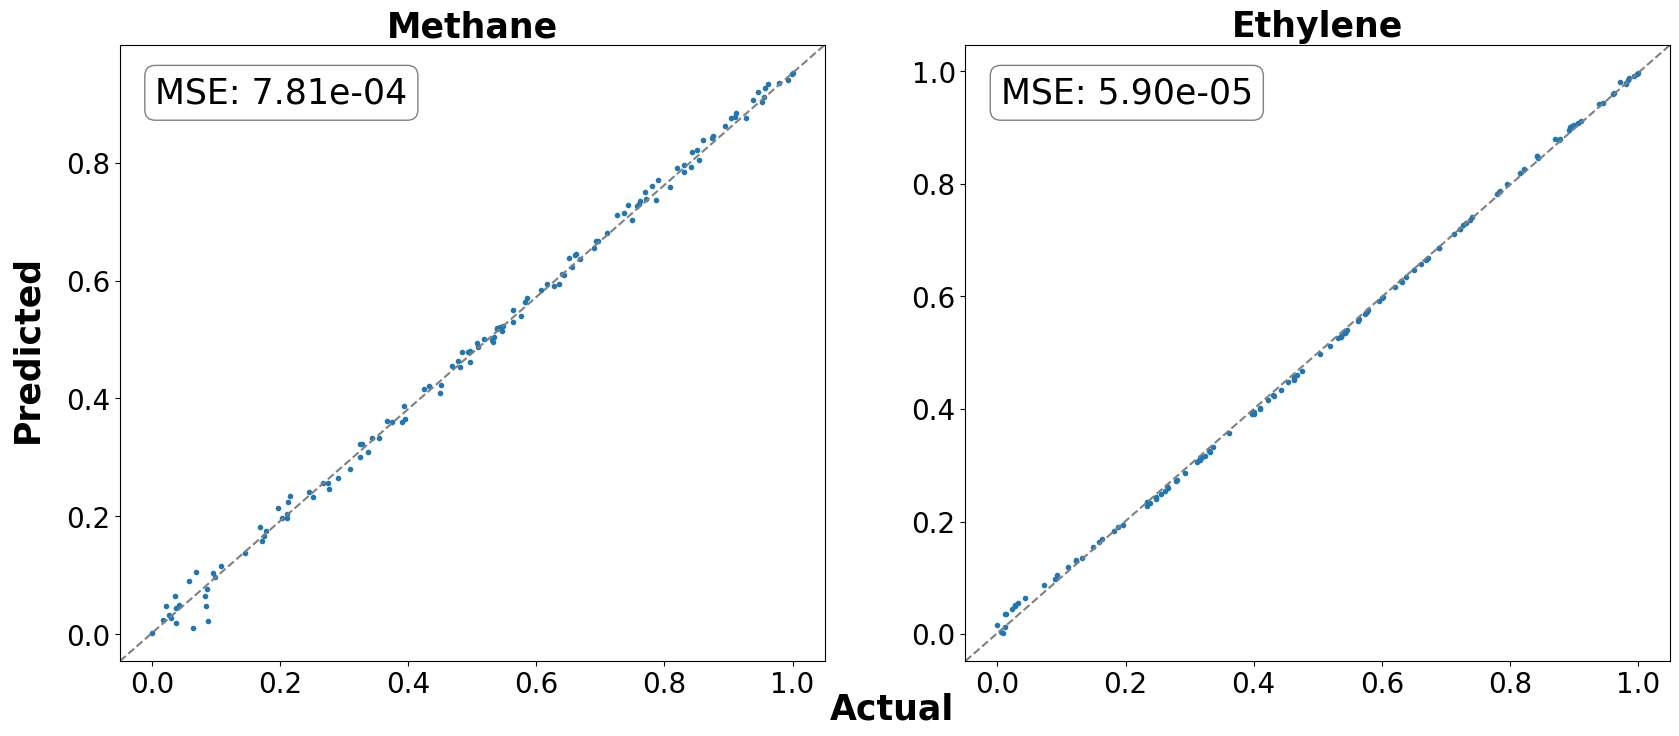

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FormatStrFormatter
from sklearn.metrics import r2_score, mean_squared_error

species = ['Methane', 'Ethylene', 'Ethane', 'Benzene', 'Propane', 'Toluene', 'Xylenes', 'Isoprene']
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharex=True)

# Assuming 'predicted' and 'true' are defined elsewhere in your code
# Plot the figures
for i, ax in enumerate(axes.flatten()):
    predicted_temp = np.reshape(predicted[i], (len(predicted[i]), 1))
    # Change plot color to navy
    ax.plot(predicted_temp[:128], true[:128, i], '.')#, color='navy')
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle='--', color='gray')  # Add identity line

    ax.set_title(species[i], fontsize=25, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=20)  # Increase tick label font size

    # Format y-axis
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

    # Calculate R-squared value
    r_squared = r2_score(true[:128, i], predicted_temp[:128].flatten())
    mse =  mean_squared_error(true[:128, i], predicted_temp[:128].flatten())

    # Display R-squared value on the top left of each subplot
    ax.text(0.05, 0.95, f'MSE: {mse:.2e}', transform=ax.transAxes, fontsize=25, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

# Set y-axis label
fig.text(0.07, 0.5, 'Predicted', va='center', rotation='vertical', fontsize=25, fontweight='bold')
fig.text(0.48, 0.05, 'Actual', va='center', rotation='horizontal', fontsize=25, fontweight='bold')

# Set x-axis label for the bottom row plots
# for ax in axes[-1]:
#     ax.set_xlabel('Actual', fontsize=20, fontweight='bold')

# plt.tight_layout()
# plt.savefig('/home/sym/BSS/figures_CLEO/BSS_8_conc_dark.png',  transparent= True, dpi=300)

plt.savefig('/home/sym/BSS/paper_figures/two/BSS_con_2.png',  transparent= True, dpi=600)
plt.savefig('/home/sym/BSS/paper_figures/two/BSS_con_2.pdf',  transparent= True, dpi=600)

plt.show()


In [8]:
ref_mix=pd.read_csv('8_x.csv' , delimiter=',' , header= None ).to_numpy()
ref_recons=pd.read_csv('8_xhat.csv' , delimiter=',' , header= None ).to_numpy()

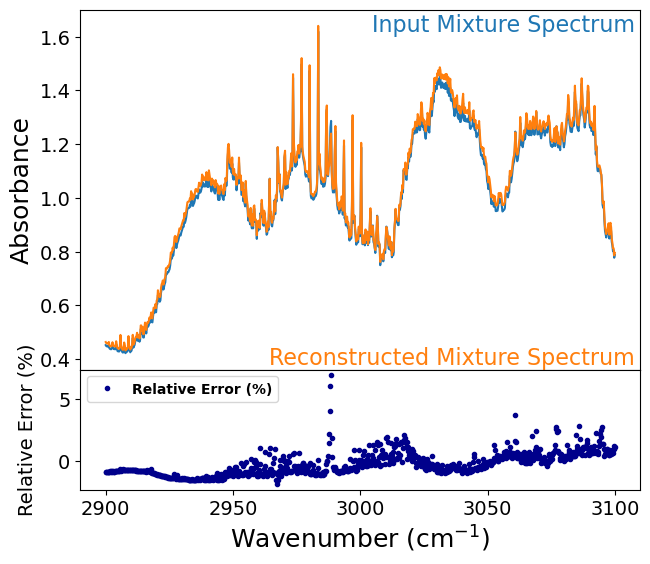

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Define the wavenumber range
v = np.linspace(2900, 3100, 830)

# Create a figure with custom dimensions and positions for subplots
fig = plt.figure(figsize=(7, 6))  # Standard figure size for the first plot

# Add the first subplot for mixture spectra, using default size
ax1 = fig.add_axes([0.1, 0.3, 0.8, 0.6])  # [left, bottom, width, height]
ax1.plot(v, ref_mix[34], label='Input Mixture Spectra')
ax1.plot(v, ref_recons[34], label='Reconstructed Mixture Spectra')
ax1.set_ylabel('Absorbance', fontsize=18)

# Add custom text for legends at the top right and bottom right
ax1.text(0.99, 0.99, 'Input Mixture Spectrum', transform=ax1.transAxes, fontsize=16, color='#1f77b4', ha='right', va='top')
ax1.text(0.99, 0.00, 'Reconstructed Mixture Spectrum', transform=ax1.transAxes, fontsize=16, color='#ff7f0e', ha='right', va='bottom')

# Custom formatter to display absolute values for y-ticks
def absolute_value_formatter(x, pos):
    return '{:.1f}'.format(abs(x))

ax1.yaxis.set_major_formatter(FuncFormatter(absolute_value_formatter))

# Hide x-axis ticks for ax1
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Add the second subplot for relative error, smaller size
ax2 = fig.add_axes([0.1, 0.1, 0.8, 0.2], sharex=ax1)  # Smaller height
relative_error = (ref_mix[1] - ref_recons[1]) * ref_mix[1] * 100 / ref_mix[1]
ax2.plot(v, relative_error, '.', label='Relative Error (%)', color='darkblue')
ax2.set_xlabel('Wavenumber (cm$^{-1}$)', fontsize=18)
ax2.legend(loc='upper left', fontsize=16, prop={'weight': 'bold'})
fig.text(0.01, 0.2, 'Relative Error (%)', va='center', rotation='vertical', fontsize=14)  # fontweight='bold')

# Set x-ticks separated by 50
ax2.set_xticks(np.arange(2900, 3101, 50))

# Set larger font size for tick labels
ax1.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)

# Optionally, adjust layout, save the figure to a file, and show the plots
plt.savefig('/home/sym/BSS/paper_figures/two/8_mix_recons_spec_and_error2.png', transparent=True, dpi=600)
plt.savefig('/home/sym/BSS/paper_figures/two/8_mix_recons_spec_and_error2.pdf', transparent=True, dpi=300)
plt.show()


## NMF 

In [10]:
from sklearn.decomposition import NMF
model = NMF(n_components=2, init='random', tol=0.00001,max_iter=1000, random_state=0)
W = model.fit_transform(dataset_clean)
H = model.components_

In [11]:
H2= [H[1], H[0]]

## Plotiing with sym axis 

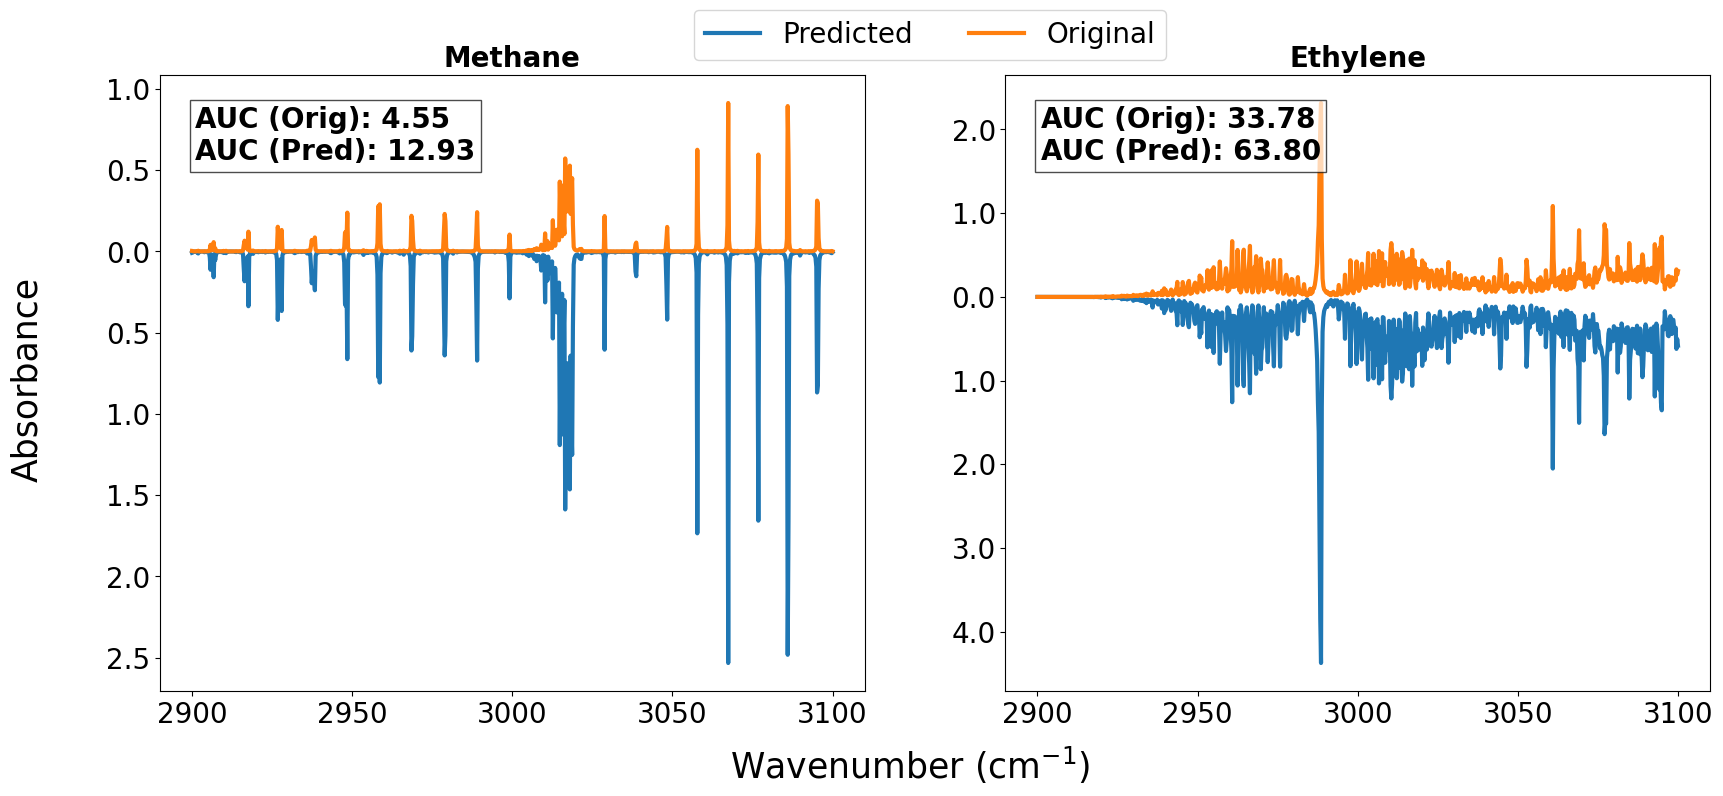

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from matplotlib.ticker import FuncFormatter

# spectras=autoencoder.decoder.r.clone().detach().cpu().numpy()
# spectras[spectras<0]=0
filtered_up=H2
# filtered_all[filtered_all<0]=0
species = ['Methane', 'Ethylene', 'Ethane', 'Benzene', 'Propane', 'Toluene', 'Xylenes', 'Isoprene']
fig, axes = plt.subplots(1, 2, figsize=(20,8), sharex=True)  # Adjusted to 4 rows and 2 columns
x_values = np.linspace(2900, 3100, 830)
df4=[df1[1]/2, df1[2]/2]
# Assuming 'filtered_updated' and 'df3' are defined elsewhere in your code

mse_list = []
mae_list = []
area_df3_list = []
area_df4_list = []

for i, ax in enumerate(axes.flatten()):
    ax.plot(x_values, -filtered_up[i], linewidth=3)
    ax.plot(x_values, df4[i], linewidth=3)
    ax.set_title(species[i], fontsize=20, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=20)  # Increase tick label font size

    # Calculate MSE and MAE
    mse = mean_squared_error(filtered_up[i], df4[i])
    mae = mean_absolute_error(filtered_up[i], df4[i])
    mse_list.append(mse)
    mae_list.append(mae)

    # Calculate area under the curve using trapz
    area_df3 = np.trapz(df4[i], x_values)
    area_df4 = np.trapz(filtered_up[i], x_values)
    area_df3_list.append(area_df3)
    area_df4_list.append(area_df4)

    # Place the legend and area under the curve text inside the subplot
    legend_text = f'AUC (Orig): {area_df3:.2f}\nAUC (Pred): {area_df4:.2f}'
    ax.text(0.05, 0.95, legend_text, transform=ax.transAxes, va='top', ha='left', fontsize=20, fontweight='bold', bbox=dict(facecolor='white', alpha=0.7))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.1f}'.format(abs(x))))

# Set common x and y labels for the entire figure
fig.text(0.5, 0.00, 'Wavenumber (cm$^{-1}$)', ha='center', fontsize=25)
fig.text(0.05, 0.5, 'Absorbance', va='center', rotation='vertical', fontsize=25)

# Add a common legend at the top of the figure
fig.legend(["Predicted", "Original"], bbox_to_anchor=(0.51, 0.93), loc='center', fontsize=20, ncol=2)

# plt.savefig('/home/sym/BSS/paper_figures/two/NMF_2_up.png', transparent=True, dpi=600)
# plt.savefig('/home/sym/BSS/paper_figures/two/NMF_2_up.pdf', transparent=True, dpi=600)
# plt.style.use('default')

plt.show()


## Sym axis

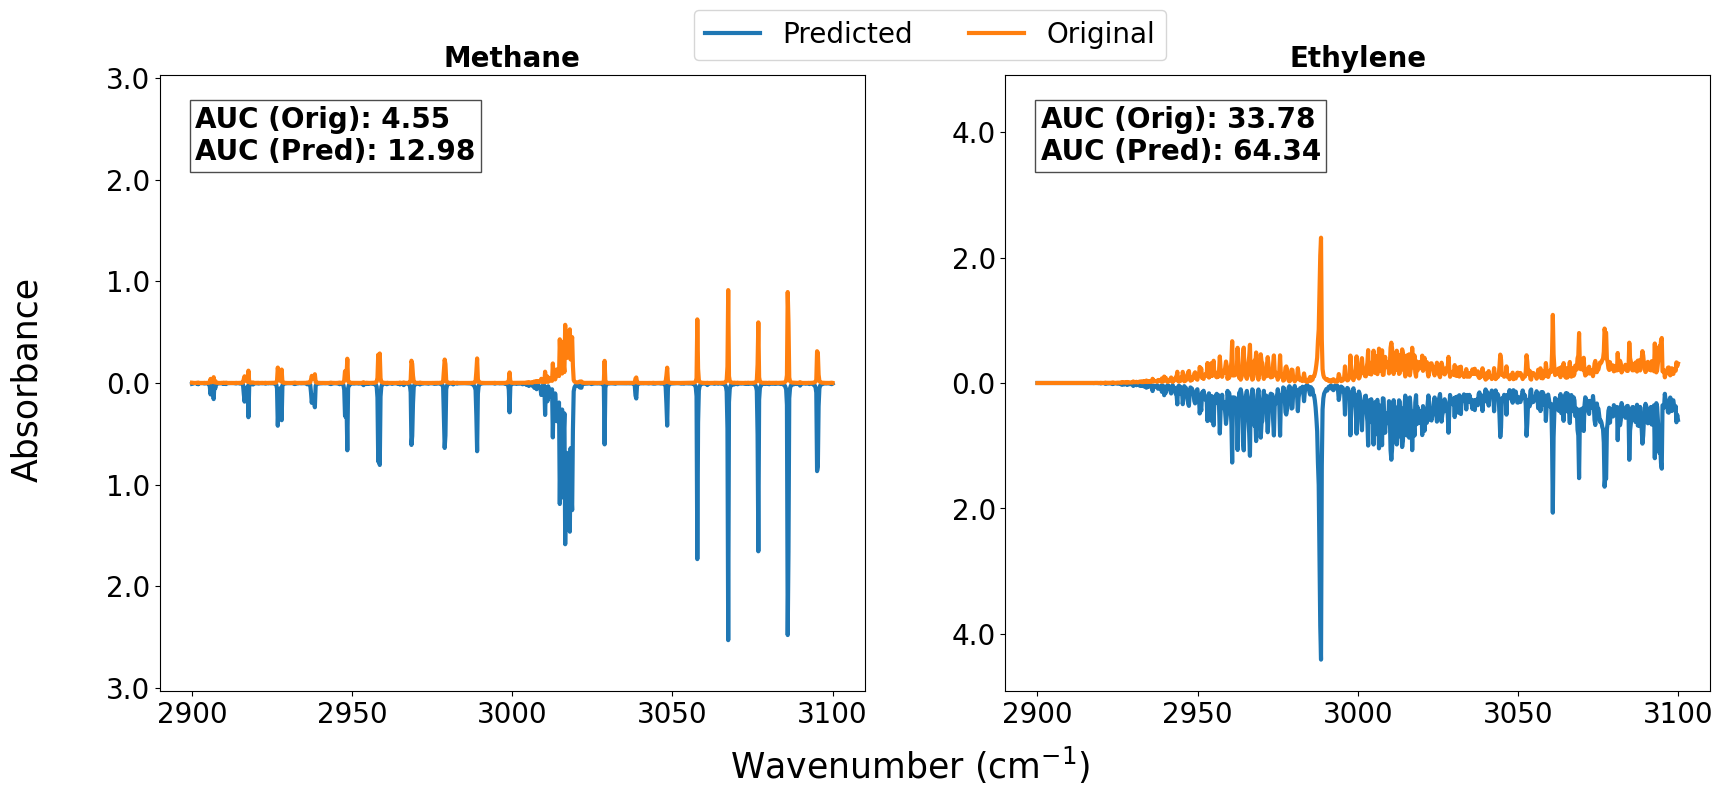

In [75]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from matplotlib.ticker import FuncFormatter

# Assuming 'filtered_up' and 'df4' are defined elsewhere in your code

fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharex=True)  # Adjusted to 4 rows and 2 columns
x_values = np.linspace(2900, 3100, 830)

mse_list = []
mae_list = []
area_df3_list = []
area_df4_list = []

for i, ax in enumerate(axes.flatten()):
    ax.plot(x_values, -filtered_up[i], linewidth=3)
    ax.plot(x_values, df4[i], linewidth=3)
    ax.set_title(species[i], fontsize=20, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=20)  # Increase tick label font size

    # Calculate MSE and MAE
    mse = mean_squared_error(filtered_up[i], df4[i])
    mae = mean_absolute_error(filtered_up[i], df4[i])
    mse_list.append(mse)
    mae_list.append(mae)

    # Calculate area under the curve using trapz
    area_df3 = np.trapz(df4[i], x_values)
    area_df4 = np.trapz(filtered_up[i], x_values)
    area_df3_list.append(area_df3)
    area_df4_list.append(area_df4)

    # Place the legend and area under the curve text inside the subplot
    legend_text = f'AUC (Orig): {area_df3:.2f}\nAUC (Pred): {area_df4:.2f}'
    ax.text(0.05, 0.95, legend_text, transform=ax.transAxes, va='top', ha='left', fontsize=20, fontweight='bold', bbox=dict(facecolor='white', alpha=0.7))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.1f}'.format(abs(x))))
    ax.set_ylim(-np.max(np.abs(filtered_up[i])+0.5), np.max(np.abs(filtered_up[i]))+0.5)  # Set y-axis limits

# Set common x and y labels for the entire figure
fig.text(0.5, 0.00, 'Wavenumber (cm$^{-1}$)', ha='center', fontsize=25)
fig.text(0.05, 0.5, 'Absorbance', va='center', rotation='vertical', fontsize=25)

# Add a common legend at the top of the figure
fig.legend(["Predicted", "Original"], bbox_to_anchor=(0.51, 0.93), loc='center', fontsize=20, ncol=2)

plt.savefig('/home/sym/BSS/paper_figures/two/NMF_2_up.png', transparent=True, dpi=600)
plt.savefig('/home/sym/BSS/paper_figures/two/NMF_2_up.pdf', transparent=True, dpi=600)
plt.style.use('default')

plt.show()


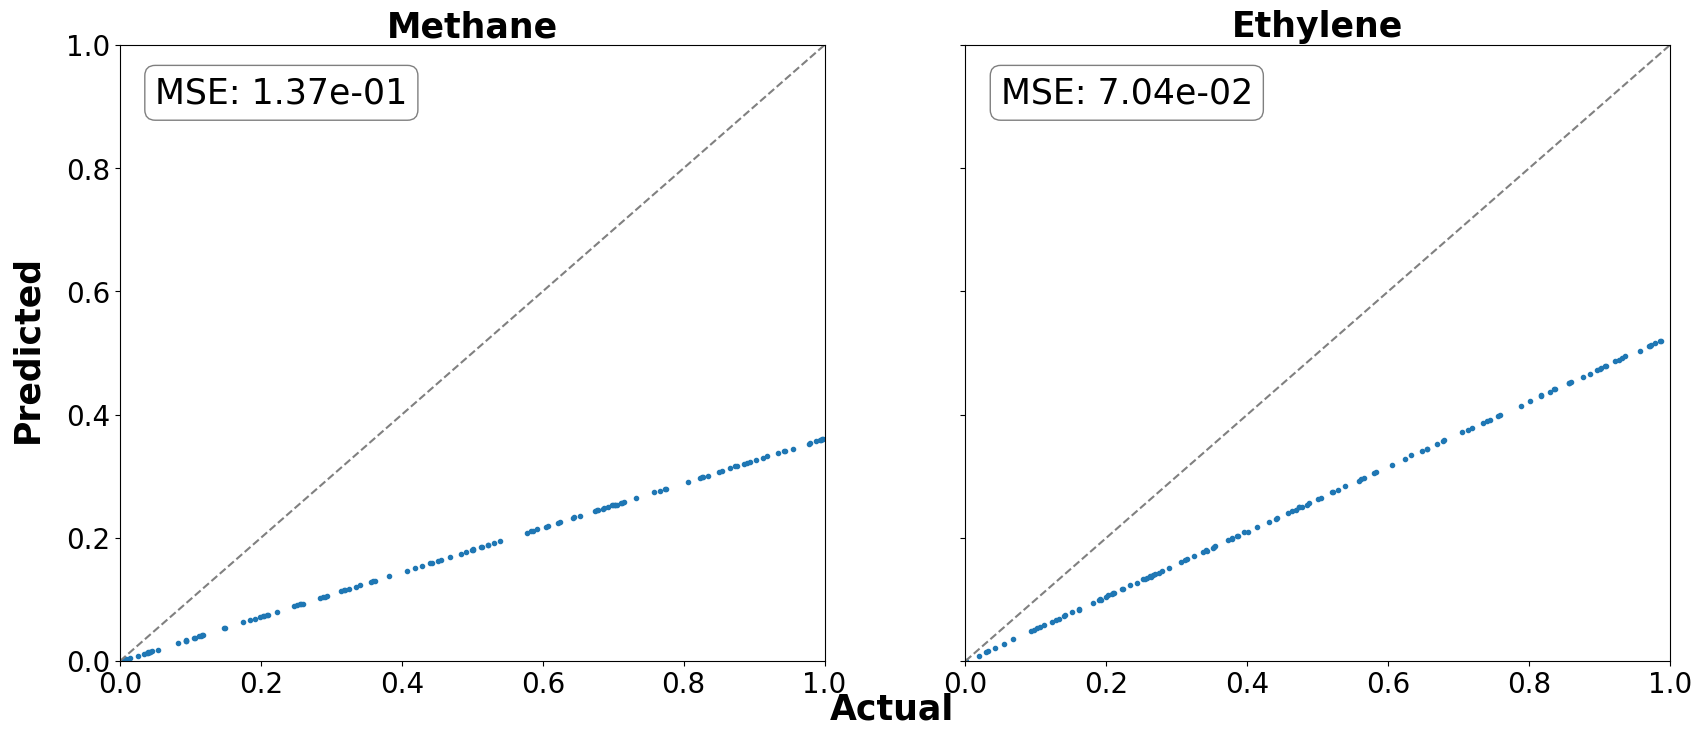

In [69]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FormatStrFormatter
from sklearn.metrics import r2_score, mean_squared_error

# Assuming 'W' and 'Con' are defined elsewhere in your code
W2 = [W[:, 1], W[:, 0]]
species = ['Methane', 'Ethylene', 'Ethane', 'Benzene', 'Propane', 'Toluene', 'Xylenes', 'Isoprene']
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharex=True, sharey=True)

# Plot the figures
for i, ax in enumerate(axes.flatten()):
    predicted_temp = np.reshape(W2[i], (len(W2[i]), 1))
    ax.plot(Con[:128, i],predicted_temp[:128],  '.')
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle='--', color='gray')  # Add identity line
    ax.set_xlim([0, 1])  # Set x-axis limits
    ax.set_ylim([0, 1])  # Set y-axis limits
    ax.set_title(species[i], fontsize=25, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=20)

    # Format y-axis
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

    # Calculate R-squared value
    r_squared = r2_score(Con[:128, i], predicted_temp[:128].flatten())
    # Display R-squared value on the top left of each subplot
    mse =  mean_squared_error(Con[:128, i], predicted_temp[:128].flatten())

    # Display R-squared value on the top left of each subplot
    ax.text(0.05, 0.95, f'MSE: {mse:.2e}', transform=ax.transAxes, fontsize=25, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

# Set y-axis label
fig.text(0.07, 0.5, 'Predicted', va='center', rotation='vertical', fontsize=25, fontweight='bold')
fig.text(0.48, 0.05, 'Actual', va='center', rotation='horizontal', fontsize=25, fontweight='bold')

plt.savefig('/home/sym/BSS/paper_figures/two/NMFcon_2.png',  transparent=True, dpi=600)
plt.savefig('/home/sym/BSS/paper_figures/two/NMF_con_2.pdf',  transparent=True, dpi=600)

plt.show()


## MCR 

In [57]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['savefig.dpi'] = 100

import pymcr
from pymcr.mcr import McrAR
from pymcr.regressors import OLS, NNLS
from pymcr.constraints import ConstraintNonneg, ConstraintNorm

from sklearn.linear_model import Ridge
number_components = 2
initial_spectra = np.random.random((number_components, 830))
mcrar = McrAR(max_iter=1000, st_regr='NNLS', c_regr=OLS(), 
                c_constraints=[ConstraintNonneg(), ConstraintNorm()])

mcrar.fit(dataset_clean, ST=initial_spectra, verbose=True)
print('\nFinal MSE: {:.7e}'.format(mcrar.err[-1]))

Iter: 1 (C)	mse: 2.2521e-01
Iter: 1 (ST)	mse: 5.4403e-03
Iter: 2 (C)	mse: 3.9065e-03
Iter: 2 (ST)	mse: 3.6201e-03
Error increased above fractionalctol_increase (C iter). Exiting

Final MSE: 3.6201297e-03


In [58]:
H2=mcrar.ST_opt_.T

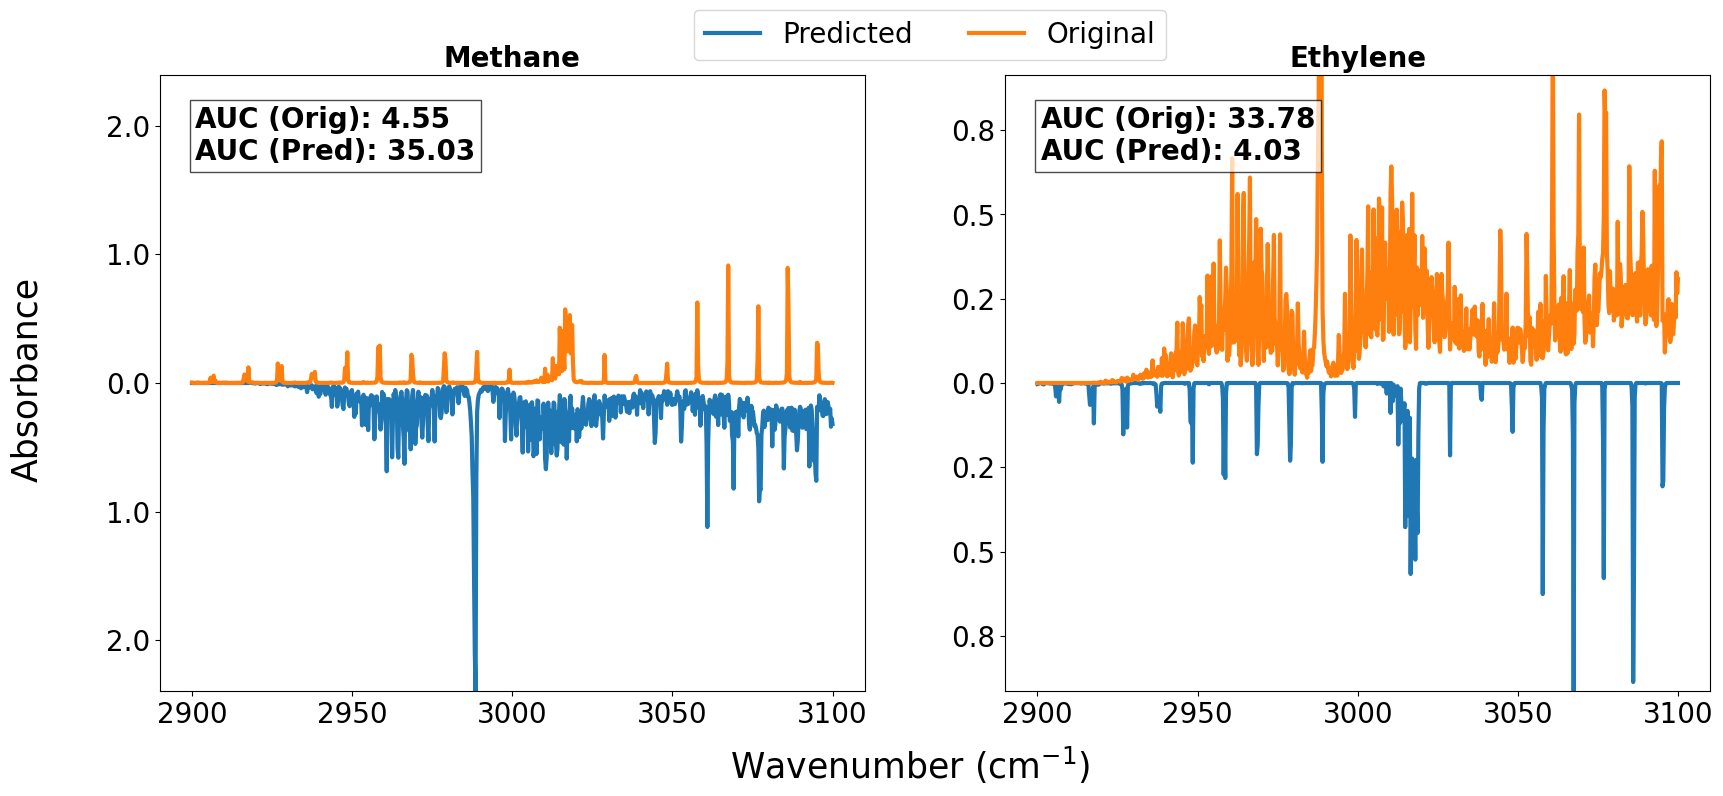

In [59]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from matplotlib.ticker import FuncFormatter

# spectras=autoencoder.decoder.r.clone().detach().cpu().numpy()
# spectras[spectras<0]=0
filtered_up=[H2[:,0], H2[:,1]]
species = ['Methane', 'Ethylene', 'Ethane', 'Benzene', 'Propane', 'Toluene', 'Xylenes', 'Isoprene']
fig, axes = plt.subplots(1, 2, figsize=(20,8), sharex=True)
x_values = np.linspace(2900, 3100, 830)
df4=[df1[1]/2, df1[2]/2]

mse_list = []
mae_list = []
area_df3_list = []
area_df4_list = []

for i, ax in enumerate(axes.flatten()):
    ax.plot(x_values, -filtered_up[i], linewidth=3)
    ax.plot(x_values, df4[i], linewidth=3)
    ax.set_title(species[i], fontsize=20, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=20)

    # Calculate MSE and MAE
    mse = mean_squared_error(filtered_up[i], df4[i])
    mae = mean_absolute_error(filtered_up[i], df4[i])
    mse_list.append(mse)
    mae_list.append(mae)

    # Calculate area under the curve using trapz
    area_df3 = np.trapz(df4[i], x_values)
    area_df4 = np.trapz(filtered_up[i], x_values)
    area_df3_list.append(area_df3)
    area_df4_list.append(area_df4)

    # Place the legend and area under the curve text inside the subplot
    legend_text = f'AUC (Orig): {area_df3:.2f}\nAUC (Pred): {area_df4:.2f}'
    ax.text(0.05, 0.95, legend_text, transform=ax.transAxes, va='top', ha='left', fontsize=20, fontweight='bold', bbox=dict(facecolor='white', alpha=0.7))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.1f}'.format(abs(x))))
    ax.set_ylim(-np.max(np.abs(filtered_up[i])), np.max(np.abs(filtered_up[i])))  # Set y-axis limits

    # Set y-axis ticks to be absolute values
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.1f}'.format(abs(x))))

# Set common x and y labels for the entire figure
fig.text(0.5, 0.00, 'Wavenumber (cm$^{-1}$)', ha='center', fontsize=25)
fig.text(0.05, 0.5, 'Absorbance', va='center', rotation='vertical', fontsize=25)

# Add a common legend at the top of the figure
fig.legend(["Predicted", "Original"], bbox_to_anchor=(0.51, 0.93), loc='center', fontsize=20, ncol=2)
# plt.savefig('/home/sym/BSS/paper_figures/two/MCR_2_up.png',  transparent= True, dpi=600)
# plt.savefig('/home/sym/BSS/paper_figures/two/MCR_2_up.pdf',  transparent= True, dpi=600)

plt.show()


In [60]:
from scipy.optimize import nnls

concentrations = []
for sample in dataset_clean:
    conc, _ = nnls(mcrar.ST_opt_.T, sample)
    concentrations.append(conc)

concentrations = np.array(concentrations)

In [136]:
np.shape(concentrations[:,1])

(10000,)

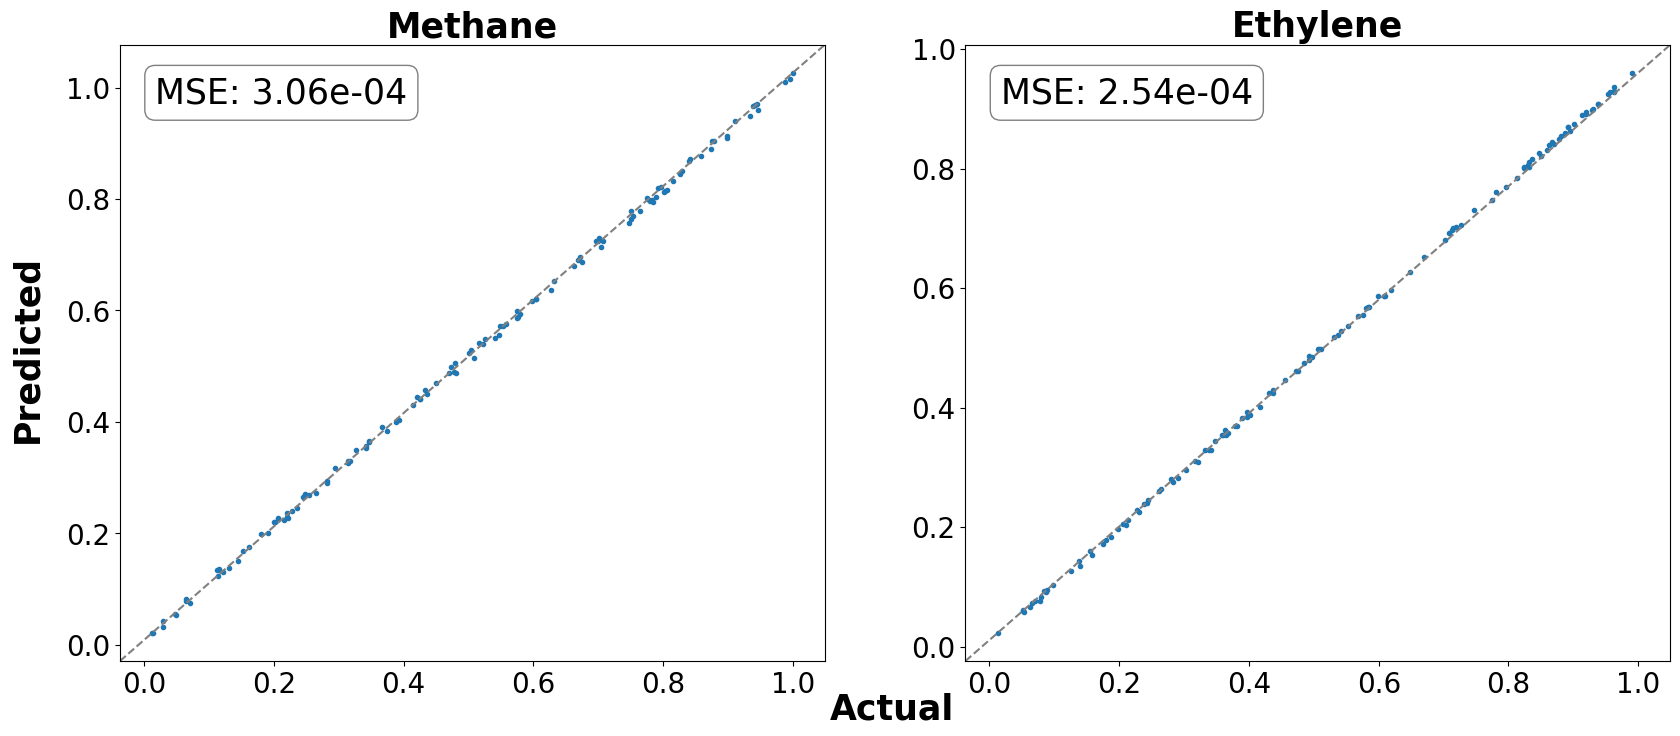

In [64]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FormatStrFormatter
from sklearn.metrics import r2_score, mean_squared_error

# W2=mcrar.C_opt_
W2=[concentrations[:,1],concentrations[:,0]]

species = ['Methane', 'Ethylene', 'Ethane', 'Benzene', 'Propane', 'Toluene', 'Xylenes', 'Isoprene']
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharex=True)

# Assuming 'predicted' and 'true' are defined elsewhere in your code

# Plot the figures
for i, ax in enumerate(axes.flatten()):
    predicted_temp = np.reshape(W2[i], (len(concentrations[:,i]), 1))
    # Change plot color to navy
    ax.plot(Con[128:254, i], predicted_temp[128:254], '.')
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle='--', color='gray')  # Add identity line
    ax.set_title(species[i], fontsize=25, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=20)  # Increase tick label font size

    # Format y-axis
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

    # Calculate R-squared value
    r_squared = r2_score(Con[:128, i], predicted_temp[:128].flatten())
    mse =  mean_squared_error(Con[:128, i], predicted_temp[:128].flatten())

    # Display R-squared value on the top left of each subplot
    ax.text(0.05, 0.95, f'MSE: {mse:.2e}', transform=ax.transAxes, fontsize=25, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

# Set y-axis label
fig.text(0.07, 0.5, 'Predicted', va='center', rotation='vertical', fontsize=25, fontweight='bold')
fig.text(0.48, 0.05, 'Actual', va='center', rotation='horizontal', fontsize=25, fontweight='bold')

plt.savefig('/home/sym/BSS/paper_figures/two/MCR_con_2.png',  transparent= True, dpi=600)
plt.savefig('/home/sym/BSS/paper_figures/two/MCR_con_2.pdf',  transparent= True, dpi=600)

plt.show()
